This short script:


1) <b>identifies the most spectrally neutral terrains within a CRISM scene;</b>
2) <b>computes the average spectrum of selected neutral pixels;</b>
3) <b>divides the entire CRISM MTRDR reflectance cube by the computed neutal spectrum and saves it as a separate cube in ENVI format</b>


This approach was first ideated by <font color='orange'>Horgan et al. 2020</font> and applied to CRISM data in Jezero crater with good results. 

In this code I provide a way to select the neutral pixels based on a certain set of spectral parameters from <font color='orange'>Viviano-Beck et al 2014</font>. The chosen parameters can be personalized based on the user's needs. In this version, I have included some additional parameters to those already listed in <font color='orange'>Horgan et al. 2020</font>'s "mineral mask" in order to take into account possible sulfate detections within the scene. 


<b>References:</b>

<i>Horgan, B. H. N., et al. (2020), The mineral diversity of Jezero crater: Evidence for possible lacustrine carbonates on Mars, Icarus, 339, doi:10.1016/j.icarus.2019.113526.</i>

<i>Viviano-Beck, C. E., et al. (2014), Revised CRISM spectral parameters and summary products based on the currently detected mineral diversity on Mars, J. Geophys. Res. Planets, 119, 1403–1431, doi:10.1002/2014JE004627.</i>

# Import

In [1]:
#open envi image
from spectral import open_image

#numpy
import numpy as np

#plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
%matplotlib inline

#pandas
import pandas as pd

#image stretching
from skimage import exposure

# Open image

In [2]:
#opening I/F file
img = open_image('data/frt00009b5a_07_if165j_mtr3.hdr')
wavelength = np.array(img.metadata['wavelength']).astype(float)
#converting img to simple array and putting no-values to NaN
nan_img = np.copy(img[:,:,:])
nan_img[nan_img>10]=np.nan

#opening refined spectral parameter file
img_sr = open_image('data/frt00009b5a_07_sr165j_mtr3.hdr')
sr_names = img_sr.metadata['band names']
#converting img_sr to simple array and putting no-values to NaN
nan_img_sr = np.copy(img_sr[:,:,:])
nan_img_sr[nan_img_sr>10]=np.nan

# Quick cube visualization

In [3]:
#some img statistics:
#----mean spectrum
mean_spec = np.nanmean(nan_img.reshape(-1,nan_img.shape[-1]), axis = 0)
#----standard dev
mean_spec_std = np.nanstd(nan_img.reshape(-1,nan_img.shape[-1]), axis = 0)

#create enhanced RGB true color image (@visible wavelengths):
wav_channels = [26,15,1] #600nm,530nm,440nm
wav_channels_text = ','.join([f'{c}:{w:.0f}nm' for c,w in zip(['R','G','B'],wavelength[wav_channels])]) #channels text for plot
RGB = img[:,:,wav_channels]

#contrast stretching: 
for ind, ch in enumerate (RGB.T):
    ch_mask = ch != 65535. #masking no-data values
    p2, p98 = np.nanpercentile(ch[ch_mask], (2, 98)) #2nd and 98th percentile ignoring no-data values (if present)
    RGB[:,:,ind] = exposure.rescale_intensity(ch, in_range=(p2, p98)).T #stretching

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


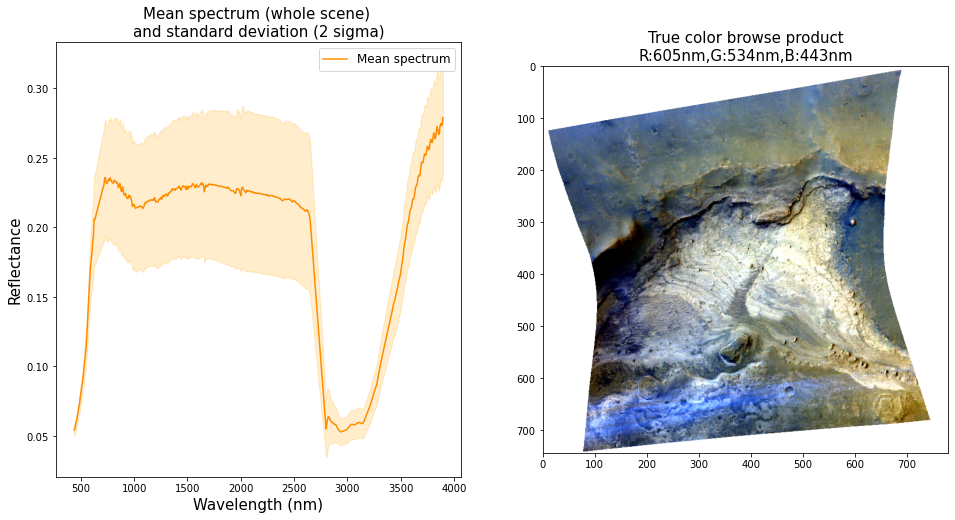

In [4]:
#plot
fig, axs = plt.subplots(ncols=2,figsize=[16,8])

#mean spectrum plot
axs[0].plot(wavelength, mean_spec, c='darkorange', label ='Mean spectrum')
axs[0].fill_between(wavelength, 
                    mean_spec-2*mean_spec_std, 
                    mean_spec+2*mean_spec_std, 
                    alpha=0.2, 
                    color='orange')
#title, labels, legend
axs[0].set_title('Mean spectrum (whole scene) \nand standard deviation (2 sigma)', size=15)
axs[0].set_xlabel('Wavelength (nm)', size=15)
axs[0].set_ylabel('Reflectance', size=15)
axs[0].legend(prop={'size': 12})

#RGB img plot
axs[1].set_title('True color browse product\n'+wav_channels_text, size = 15)
axs[1].imshow(RGB)

# Cube ratioing - build mask

## Mineral mask

In [6]:
#define a spectral parameter pandas dataframe
df_sr = pd.DataFrame(nan_img_sr.reshape(-1,nan_img_sr.shape[-1]),
            columns=img_sr.metadata['band names']
            )

#mineral mask constraints, modified after Horgan et al. 2020
#second element of constraints is the threshold value used to build the mask
#thresholds below are indicative and change with data, try playing with them! 
constraints = (
    ('R770'    ,0.23), 
    ('BDI1000IR'    ,0.035),
    ('OLINDEX3',0.09),
    ('BD1300', 0.000),
    ('LCPINDEX2', 0.005),
    ('HCPINDEX2', 0.005),
    ('D2200'   ,0.00), 
    ('BD2290', 0.00), 
    ('D2300', 0.00), 
    ('BD2500_2', 0), 
    ('SINDEX2', 0.0045), 
    ('BD1900_2', 0.006) 
    
)

band_names_mask = [i for i,j in constraints] 
constr_values = [j for i,j in constraints]

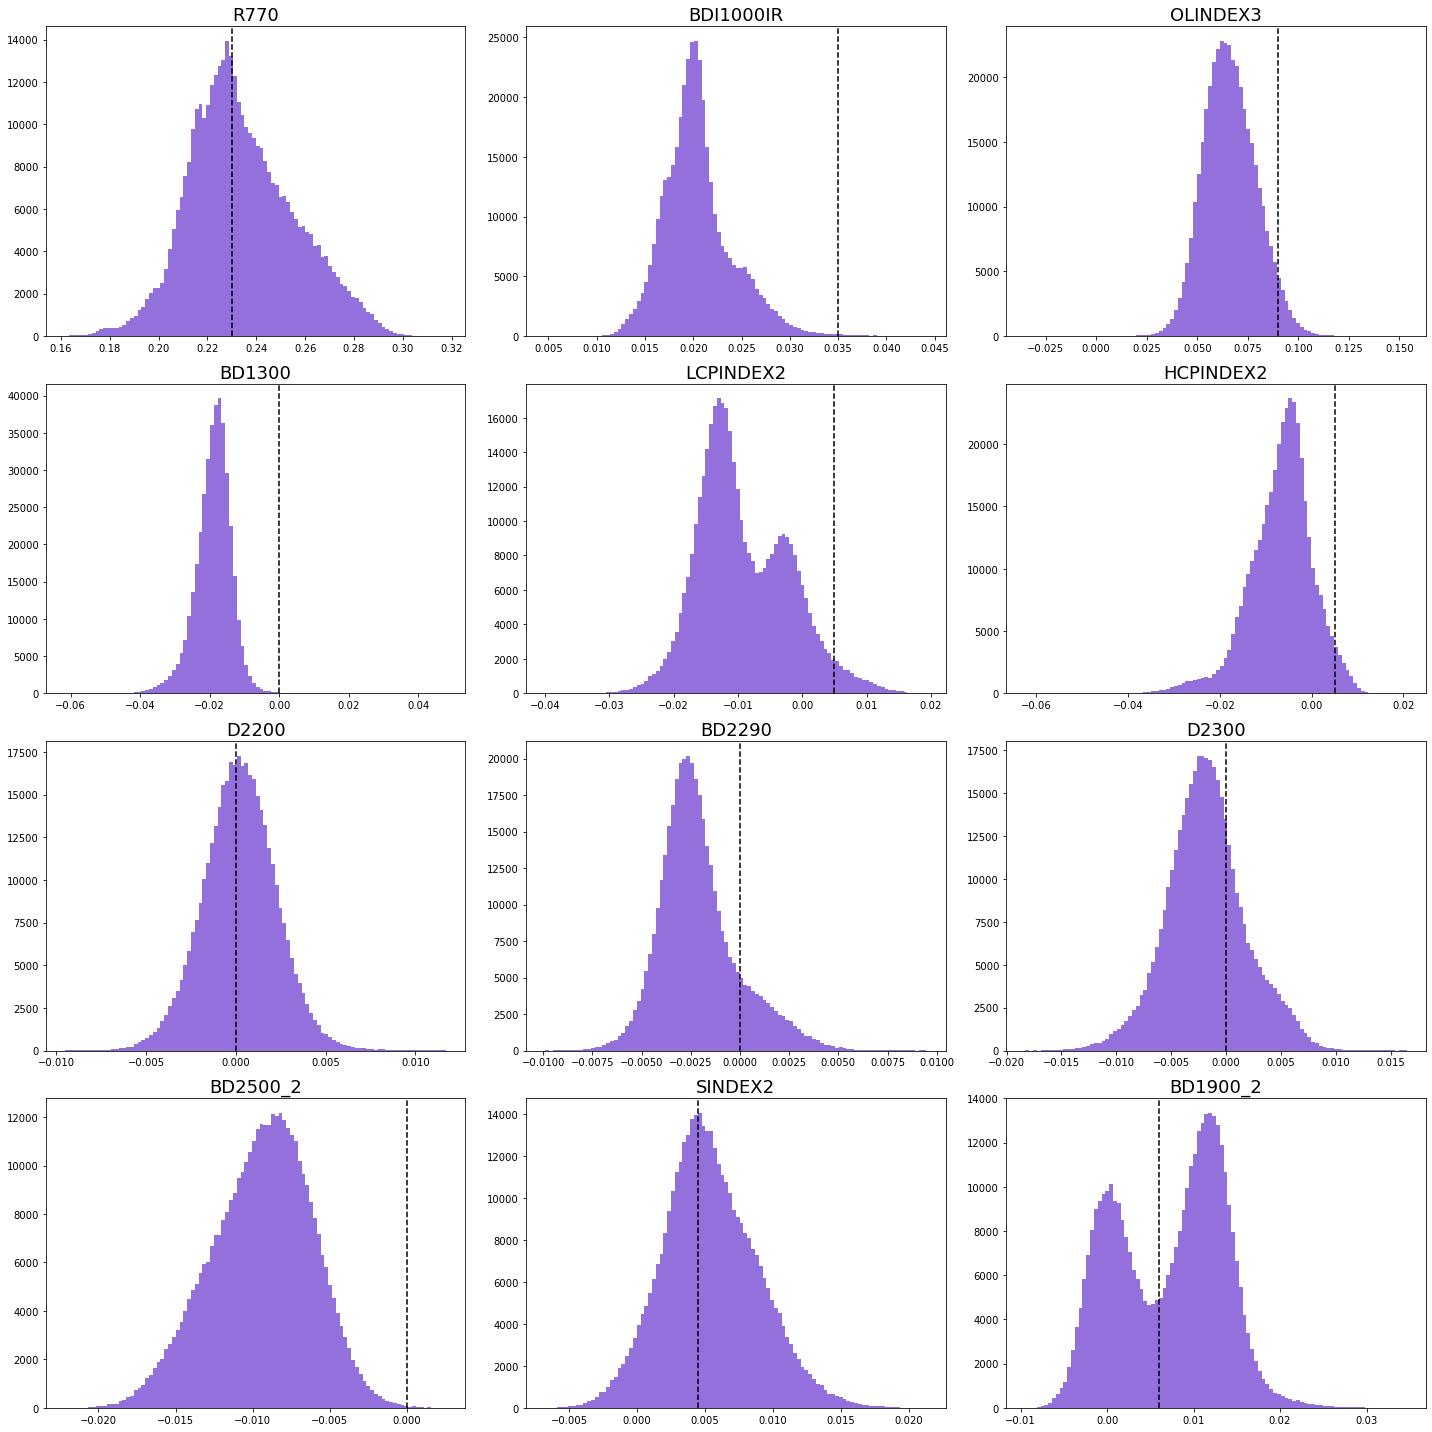

In [11]:
#histograms
histograms = df_sr[band_names_mask].hist(figsize=(20,20), bins=100, grid=False, color = 'mediumpurple')

#plotting
for i, h in enumerate(histograms.ravel()):
    h.title.set_size(18)
    h.axvline(constr_values[i], color='k', linestyle='--')
    
plt.tight_layout()

## Build and visualize mineral mask

In [14]:
#function to retrieve band index
def get_band_index(img,x):
    return img.metadata['band names'].index(x)

In [15]:
#building mineral mask 
constraints_ls = [] #each element of this list will contain an array with True/False values based on required condition

for b,v in constraints:
    if b == 'R770':
        #print(b,v)
        constraints_ls.append((img_sr[:,:,get_band_index(img_sr,b)] > v).squeeze()) #take all pixels with R770 > threshold
    else:
        #print(b,v)
        constraints_ls.append((img_sr[:,:,get_band_index(img_sr,b)] < v).squeeze()) #take all pixels with other params < threshold

constraints_mask = np.array(constraints_ls).sum(axis=0) == len(constraints_ls) #True = elements with all constraints true
print('Number of pixels selected by the mask = {}'.format(constraints_mask.sum()))

Number of pixels selected by the mask = 7791


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


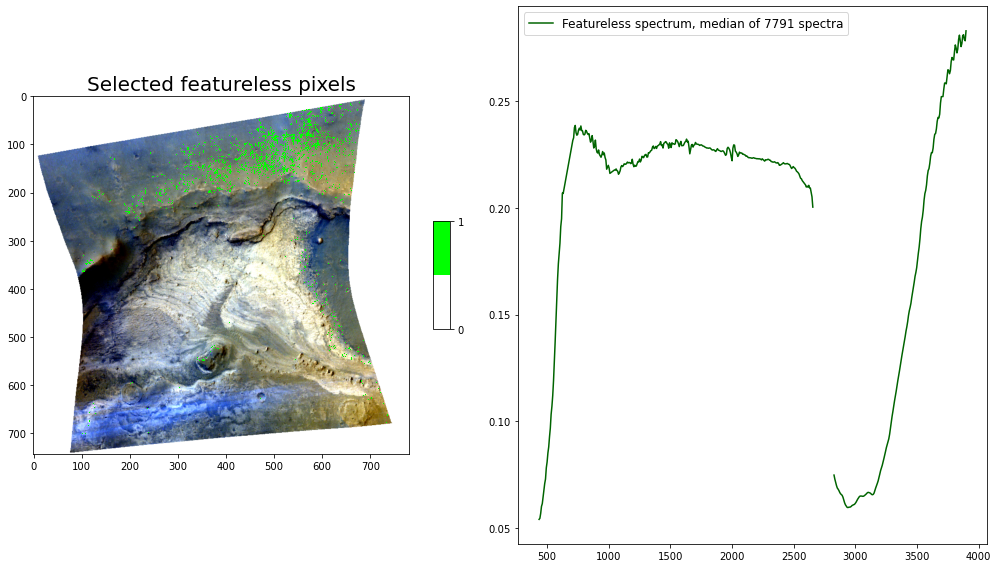

In [21]:
#plots
fig, axs = plt.subplots(ncols = 2, figsize=(14,8))

#title 
axs[0].set_title('Selected featureless pixels', size = 20)
#plot base image
axs[0].imshow(RGB)
#cmap
cmap = colors.ListedColormap(['#00000000', '#00ff00']) 
#plot mask
mm_img = axs[0].imshow(constraints_mask, interpolation='None', cmap = cmap)
#plot colorbar
plt.colorbar(mm_img, ax = axs[0], ticks=[0,1], shrink=.2, aspect=6)


#computing mean or median of featureless spectra

#fless_mean_spec = np.mean(nan_img[constraints_mask==True,:], axis = 0)
fless_median_spec = np.median(nan_img[constraints_mask==True,:], axis = 0)

#spectrum plot
axs[1].plot(wavelength,
            fless_median_spec,
            c='darkgreen', 
            label ='Featureless spectrum, median of {} spectra'.format(constraints_mask.sum()))

axs[1].legend(prop={'size': 12})

plt.tight_layout()

# Cube ratioing - compute ratioed cube

In [22]:
#compute ratioed cube 

ratioed_cube = np.array(nan_img.shape)
ratioed_cube = nan_img/(fless_median_spec)


# Save ratioed cube in ENVI format

In [18]:
import pathlib #https://pbpython.com/pathlib-intro.html
#save envi image
from spectral.io.envi import save_image

In [19]:
#path
file_path = pathlib.Path('data/ratio/frt00009b5a_07_if165j_mtr3.hdr').resolve()
file_path.parent / (file_path.stem + '_RATIOED.img')

PosixPath('/Users/beatrice/Documents/PHD/DLR/Codici python/data/ratio/frt00009b5a_07_if165j_mtr3_RATIOED.img')

In [20]:
#save image
save_image(file_path.parent / (file_path.stem + '_RATIOED.hdr') , ratioed_cube, force = True, dtype=np.float32)